# Installations

In [ ]:
! pip install tensorflow keras numpy pandas matplotlib

# Import libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# FER2013

### Data exploration

In [2]:
df = pd.read_csv('fer2013/fer2013.csv')
df.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [ ]:
# total number of rows a.k.a. total number of records in the dataset
df.shape[0]

35887

In [ ]:
label_to_text = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [ ]:
# Frequency of each emotion in the dataset.
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
label_to_text = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
count_dict = {label_to_text[i]:df['emotion'].value_counts()[i] for i in df['emotion'].value_counts().index}
count_dict = pd.Series(count_dict)
count_dict

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
dtype: int64

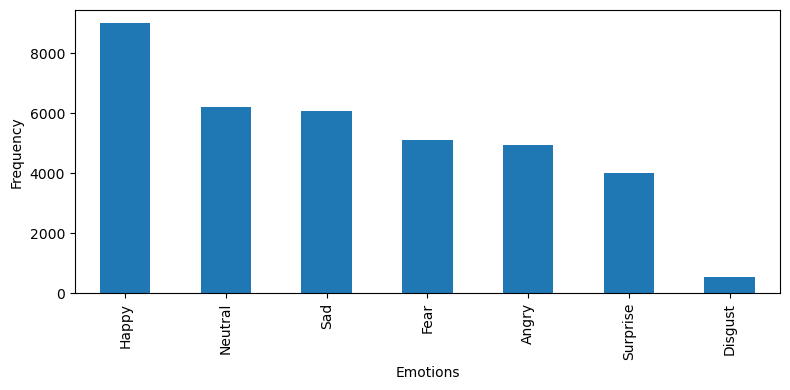

In [ ]:
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
count_dict.plot(ax=ax, kind='bar', xlabel='Emotions', ylabel='Frequency')

plt.show()

In [ ]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
train_set = df[df['Usage'] == 'Training']
val_set = df[df['Usage'] == 'PrivateTest']
test_set = df[df['Usage'] == 'PublicTest']

print('Length of train set: ', train_set.shape[0])
print('Length of validation set: ', val_set.shape[0])
print('Length of test set: ', test_set.shape[0])

Length of train set:  28709
Length of validation set:  3589
Length of test set:  3589


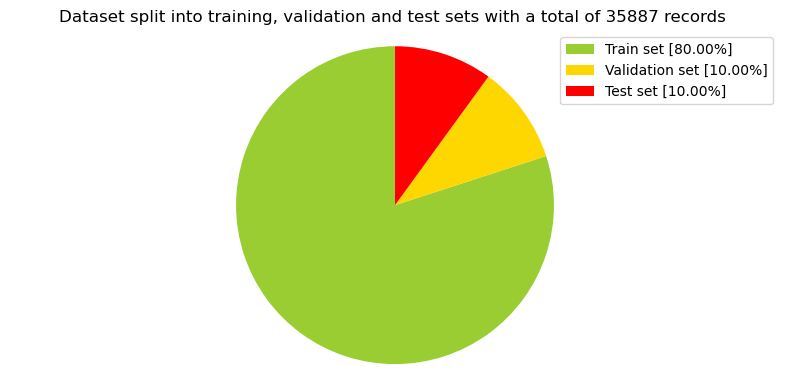

In [ ]:
## Print the Pie Chart ##
labels = ['Train set ['+str(format((train_set.shape[0]/df.shape[0])*100, '.2f'))+'%]', 
          'Validation set ['+str(format((val_set.shape[0]/df.shape[0])*100, '.2f'))+'%]', 
          'Test set ['+str(format((test_set.shape[0]/df.shape[0])*100, '.2f'))+'%]']

sizes = [(train_set.shape[0]/df.shape[0])*100, (val_set.shape[0]/df.shape[0])*100, (test_set.shape[0]/df.shape[0])*100]
colors = ['yellowgreen', 'gold', 'red']
patches, texts = plt.pie(sizes, colors = colors, startangle = 90)
plt.legend(patches, labels, loc = "best")
plt.title("Dataset split into training, validation and test sets with a total of " + str(df.shape[0]) + " records ")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
train_set['emotion'].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [ ]:
count_dict_train = {label_to_text[i]:train_set['emotion'].value_counts()[i] for i in train_set['emotion'].value_counts().index}

count_dict_train = pd.Series(count_dict_train)
count_dict_train

Happy       7215
Neutral     4965
Sad         4830
Fear        4097
Angry       3995
Surprise    3171
Disgust      436
dtype: int64

In [ ]:
val_set['emotion'].value_counts()

3    879
6    626
4    594
2    528
0    491
5    416
1     55
Name: emotion, dtype: int64

In [ ]:
count_dict_val = {label_to_text[i]:val_set['emotion'].value_counts()[i] for i in val_set['emotion'].value_counts().index}

count_dict_val = pd.Series(count_dict_val)
count_dict_val

Happy       879
Neutral     626
Sad         594
Fear        528
Angry       491
Surprise    416
Disgust      55
dtype: int64

In [ ]:
test_set['emotion'].value_counts()

3    895
4    653
6    607
2    496
0    467
5    415
1     56
Name: emotion, dtype: int64

In [ ]:
count_dict_test = {label_to_text[i]:test_set['emotion'].value_counts()[i] for i in test_set['emotion'].value_counts().index}

count_dict_test = pd.Series(count_dict_test)
count_dict_test

Happy       895
Sad         653
Neutral     607
Fear        496
Angry       467
Surprise    415
Disgust      56
dtype: int64

### Data Preprocessing

In [ ]:
# Split data into training, validation, and test sets
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

In [ ]:
train_df['pixels'].iloc[0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [ ]:
# Convert pixel strings to numpy arrays
X_train = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in train_df['pixels']])
X_val = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in val_df['pixels']])
X_test = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in test_df['pixels']])

X_train[0]

array([ 70,  80,  82, ..., 106, 109,  82])

In [ ]:
# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train[0]

array([0.2745098 , 0.31372549, 0.32156863, ..., 0.41568627, 0.42745098,
       0.32156863])

In [ ]:
X_train[0].shape

(2304,)

In [ ]:
# Reshape arrays to 48x48x1 (1 channel for grayscale images)
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

X_train[0].shape

(48, 48, 1)

In [ ]:
train_df['emotion'].iloc[0]

0

In [ ]:
# Convert emotion labels to categorical arrays
y_train = tf.keras.utils.to_categorical(train_df['emotion'], num_classes=7)
y_val = tf.keras.utils.to_categorical(val_df['emotion'], num_classes=7)
y_test = tf.keras.utils.to_categorical(test_df['emotion'], num_classes=7)

y_train[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Simple CNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(48,48,1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(units=7, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
file_name = 'best_model.h5'

checkpoint_path= os.path.join('checkpoint', file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_frequency='epoch',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                mode='max')

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), callbacks=call_back)

Epoch 1/20
449/449 [==============================] - ETA: 0s - loss: 1.8156 - accuracy: 0.2491
Epoch 1: val_accuracy improved from -inf to 0.26135, saving model to checkpoint\best_model.h5
449/449 [==============================] - 320s 713ms/step - loss: 1.8156 - accuracy: 0.2491 - val_loss: 1.7839 - val_accuracy: 0.2614
Epoch 2/20
449/449 [==============================] - ETA: 0s - loss: 1.7031 - accuracy: 0.3154
Epoch 2: val_accuracy improved from 0.26135 to 0.42017, saving model to checkpoint\best_model.h5
449/449 [==============================] - 318s 707ms/step - loss: 1.7031 - accuracy: 0.3154 - val_loss: 1.5261 - val_accuracy: 0.4202
Epoch 3/20
449/449 [==============================] - ETA: 0s - loss: 1.5223 - accuracy: 0.4076
Epoch 3: val_accuracy improved from 0.42017 to 0.45444, saving model to checkpoint\best_model.h5
449/449 [==============================] - 347s 773ms/step - loss: 1.5223 - accuracy: 0.4076 - val_loss: 1.4212 - val_accuracy: 0.4544
Epoch 4/20
449/449 

113/113 [==============================] - 10s 87ms/step
              precision    recall  f1-score   support

           0       0.61      0.42      0.50       491
           1       0.71      0.45      0.56        55
           2       0.54      0.31      0.40       528
           3       0.82      0.86      0.84       879
           4       0.42      0.61      0.50       594
           5       0.74      0.79      0.76       416
           6       0.56      0.61      0.59       626

    accuracy                           0.62      3589
   macro avg       0.63      0.58      0.59      3589
weighted avg       0.63      0.62      0.61      3589



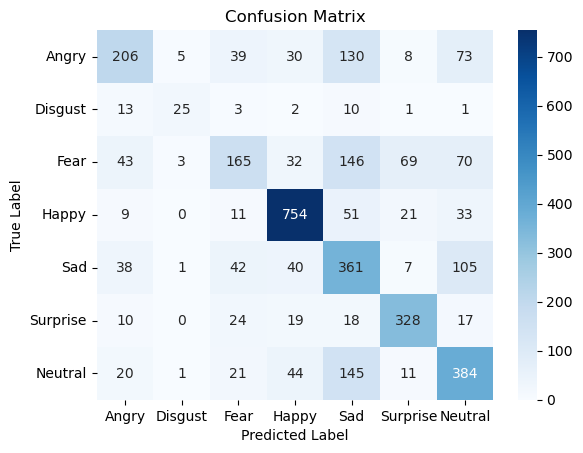

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# model = keras.models.load_model('checkpoint/best_model_enhanced.h5')

label_to_text = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
classes = list(label_to_text.values())
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(np.argmax(y_test, axis=-1), y_pred))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=-1), y_pred), annot=True, cmap='Blues',fmt='g', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

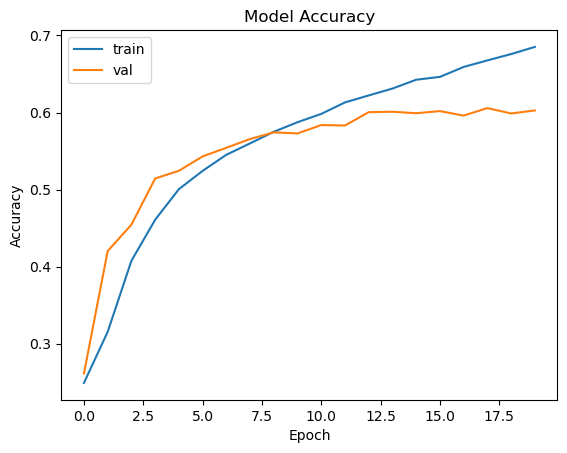

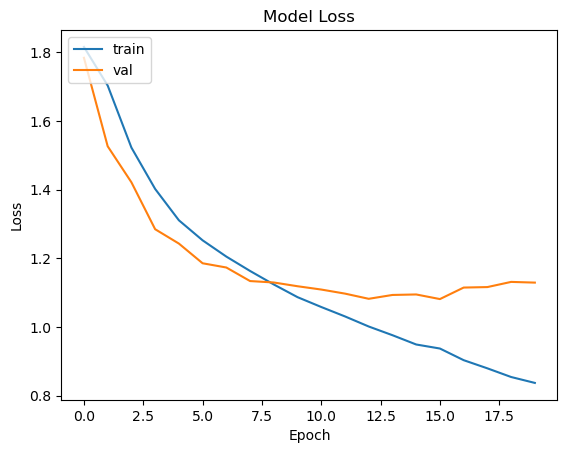

In [ ]:
import matplotlib.pyplot as plt

# plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Transfer learning

##### VGG-16

In [ ]:
file_name = 'vgg_best_model.h5'

checkpoint_path= os.path.join('checkpoint', file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_frequency='epoch',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                mode='max')

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# extract pixel values and labels from dataset

train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

X_train = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in train_df['pixels']])
X_val = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in val_df['pixels']])
X_test = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in test_df['pixels']])

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)


X_train = np.concatenate([X_train, X_train, X_train], axis=-1)
X_val = np.concatenate([X_val, X_val, X_val], axis=-1)
X_test = np.concatenate([X_test, X_test, X_test], axis=-1)

# Convert emotion labels to categorical arrays
y_train = tf.keras.utils.to_categorical(train_df['emotion'], num_classes=7)
y_val = tf.keras.utils.to_categorical(val_df['emotion'], num_classes=7)
y_test = tf.keras.utils.to_categorical(test_df['emotion'], num_classes=7)


# load pre-trained VGG-16 model without top layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))



# freeze VGG-16 layers
for layer in vgg_model.layers:
    layer.trainable = False

# add top layers to the model
model = keras.Sequential([
    vgg_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), callbacks=call_back)

58889256/58889256 [==============================] - 4s 0us/step


Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.6492 - accuracy: 0.3477
Epoch 1: val_accuracy improved from -inf to 0.39510, saving model to checkpoint/vgg_best_model.h5
449/449 [==============================] - 20s 24ms/step - loss: 1.6492 - accuracy: 0.3477 - val_loss: 1.5648 - val_accuracy: 0.3951
Epoch 2/50
448/449 [============================>.] - ETA: 0s - loss: 1.5708 - accuracy: 0.3876
Epoch 2: val_accuracy improved from 0.39510 to 0.39621, saving model to checkpoint/vgg_best_model.h5
449/449 [==============================] - 10s 22ms/step - loss: 1.5707 - accuracy: 0.3875 - val_loss: 1.5507 - val_accuracy: 0.3962
Epoch 3/50
448/449 [============================>.] - ETA: 0s - loss: 1.5365 - accuracy: 0.4028
Epoch 3: val_accuracy improved from 0.39621 to 0.41739, saving model to checkpoint/vgg_best_model.h5
449/449 [==============================] - 10s 22ms/step - loss: 1.5367 - accuracy: 0.4026 - val_loss: 1.5215 - val_accuracy: 0.4174
Epoch 4/50
44

113/113 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.43      0.35      0.38       491
           1       0.77      0.55      0.64        55
           2       0.38      0.39      0.39       528
           3       0.59      0.59      0.59       879
           4       0.40      0.42      0.41       594
           5       0.69      0.66      0.67       416
           6       0.42      0.48      0.45       626

    accuracy                           0.49      3589
   macro avg       0.53      0.49      0.50      3589
weighted avg       0.49      0.49      0.49      3589



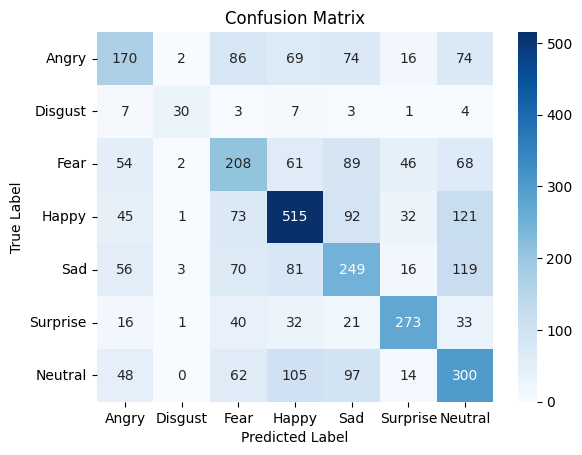

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# model = keras.models.load_model('checkpoint/best_model_enhanced.h5')

label_to_text = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
classes = list(label_to_text.values())
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(np.argmax(y_test, axis=-1), y_pred))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=-1), y_pred), annot=True, cmap='Blues',fmt='g', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### ResNet-50

In [3]:
file_name = 'resNet_best_model.h5'

checkpoint_path= os.path.join('checkpoint', file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_frequency='epoch',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                mode='max')
# call_back2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [12]:

# extract pixel values and labels from dataset

train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

X_train = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in train_df['pixels']])
X_val = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in val_df['pixels']])
X_test = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in test_df['pixels']])

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)


X_train = np.concatenate([X_train, X_train, X_train], axis=-1)
X_val = np.concatenate([X_val, X_val, X_val], axis=-1)
X_test = np.concatenate([X_test, X_test, X_test], axis=-1)

# Convert emotion labels to categorical arrays
y_train = tf.keras.utils.to_categorical(train_df['emotion'], num_classes=7)
y_val = tf.keras.utils.to_categorical(val_df['emotion'], num_classes=7)
y_test = tf.keras.utils.to_categorical(test_df['emotion'], num_classes=7)


# load pre-trained VGG-16 model without top layer
resnet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))



# freeze VGG-16 layers
for layer in resnet50_base_model.layers:
    layer.trainable = False

# add top layers to the model
model = keras.Sequential([
    resnet50_base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), callbacks=[call_back])

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.9103 - accuracy: 0.2389
Epoch 1: val_accuracy improved from -inf to 0.24937, saving model to checkpoint/resnet50_base_model.h5
449/449 [==============================] - 17s 29ms/step - loss: 1.9103 - accuracy: 0.2389 - val_loss: 1.7939 - val_accuracy: 0.2494
Epoch 2/50
448/449 [============================>.] - ETA: 0s - loss: 1.8065 - accuracy: 0.2504
Epoch 2: val_accuracy did not improve from 0.24937
449/449 [==============================] - 10s 23ms/step - loss: 1.8064 - accuracy: 0.2505 - val_loss: 1.7787 - val_accuracy: 0.2494
Epoch 3/50
448/449 [============================>.] - ETA: 0s - loss: 1.7969 - accuracy: 0.2523
Epoch 3: val_accuracy improved from 0.24937 to 0.26721, saving model to checkpoint/resnet50_base_model.h5
449/449 [==============================] - 11s 25ms/step - loss: 1.7969 - accuracy: 0.2523 - val_loss: 1.7731 - val_accuracy: 0.2672
Epoch 4/50
447/449 [============================>.] -

113/113 [==============================] - 2s 11ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      0.00      0.00       491
           1       0.00      0.00      0.00        55
           2       0.27      0.14      0.18       528
           3       0.27      0.95      0.42       879
           4       0.00      0.00      0.00       594
           5       0.61      0.30      0.40       416
           6       0.00      0.00      0.00       626

    accuracy                           0.29      3589
   macro avg       0.24      0.20      0.14      3589
weighted avg       0.25      0.29      0.18      3589



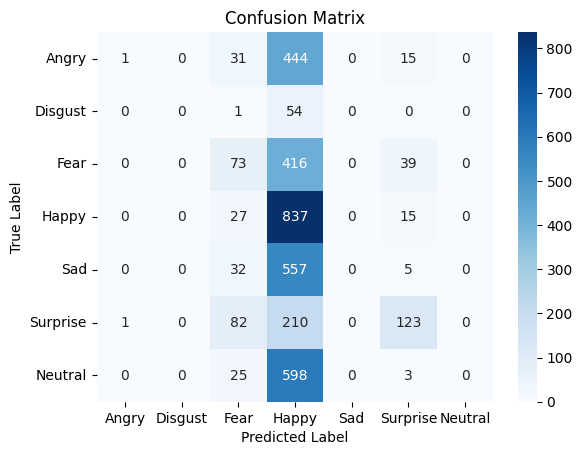

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# model = keras.models.load_model('checkpoint/best_model_enhanced.h5')

label_to_text = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
classes = list(label_to_text.values())
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(np.argmax(y_test, axis=-1), y_pred))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=-1), y_pred), annot=True, cmap='Blues',fmt='g', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

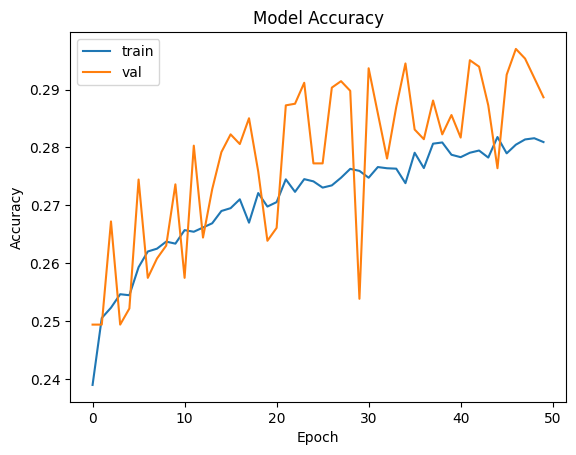

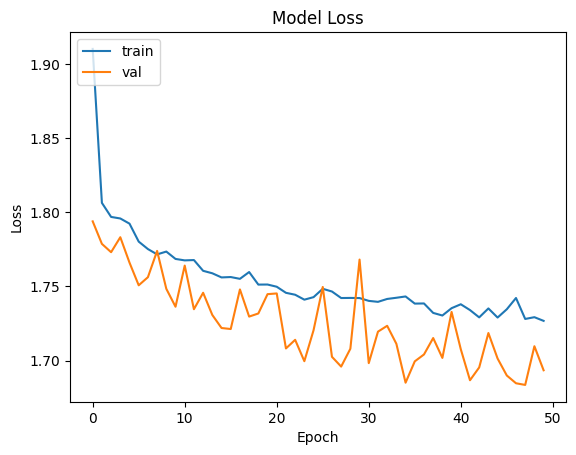

In [14]:
import matplotlib.pyplot as plt

# plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### DenseNet121


In [3]:
file_name = 'denseNet_best_model.h5'

checkpoint_path= os.path.join('checkpoint', file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_frequency='epoch',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                mode='max')
call_back2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.applications.densenet import DenseNet121
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# extract pixel values and labels from dataset

train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

X_train = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in train_df['pixels']])
X_val = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in val_df['pixels']])
X_test = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in test_df['pixels']])

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)


X_train = np.concatenate([X_train, X_train, X_train], axis=-1)
X_val = np.concatenate([X_val, X_val, X_val], axis=-1)
X_test = np.concatenate([X_test, X_test, X_test], axis=-1)

# Convert emotion labels to categorical arrays
y_train = tf.keras.utils.to_categorical(train_df['emotion'], num_classes=7)
y_val = tf.keras.utils.to_categorical(val_df['emotion'], num_classes=7)
y_test = tf.keras.utils.to_categorical(test_df['emotion'], num_classes=7)


# load pre-trained AlexNet model without top layer
eff_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(48, 48, 3))



# freeze AlexNet layers
for layer in eff_model.layers:
    layer.trainable = False

# add top layers to the model
model = keras.Sequential([
    eff_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), callbacks=[call_back, call_back2])

29084464/29084464 [==============================] - 1s 0us/step
Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.6603 - accuracy: 0.3560
Epoch 1: val_accuracy improved from -inf to 0.39928, saving model to checkpoint/denseNet_best_model.h5
449/449 [==============================] - 31s 33ms/step - loss: 1.6603 - accuracy: 0.3560 - val_loss: 1.5387 - val_accuracy: 0.3993
Epoch 2/50
447/449 [============================>.] - ETA: 0s - loss: 1.5419 - accuracy: 0.4039
Epoch 2: val_accuracy improved from 0.39928 to 0.41571, saving model to checkpoint/denseNet_best_model.h5
449/449 [==============================] - 12s 27ms/step - loss: 1.5417 - accuracy: 0.4041 - val_loss: 1.4990 - val_accuracy: 0.4157
Epoch 3/50
448/449 [============================>.] - ETA: 0s - loss: 1.5082 - accuracy: 0.4187
Epoch 3: val_accuracy improved from 0.41571 to 0.41767, saving model to checkpoint/denseNet_best_model.h5
449/449 [==============================] - 11s 25ms/step - loss: 1

113/113 [==============================] - 5s 15ms/step
              precision    recall  f1-score   support

           0       0.43      0.36      0.39       491
           1       0.85      0.40      0.54        55
           2       0.40      0.35      0.37       528
           3       0.56      0.68      0.61       879
           4       0.37      0.36      0.37       594
           5       0.67      0.62      0.64       416
           6       0.42      0.46      0.44       626

    accuracy                           0.48      3589
   macro avg       0.53      0.46      0.48      3589
weighted avg       0.48      0.48      0.48      3589



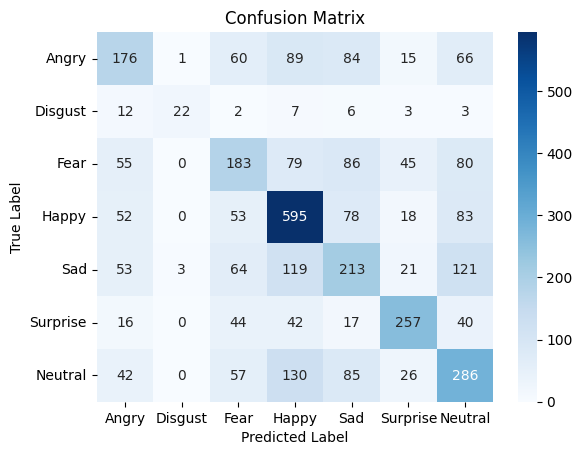

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# model = keras.models.load_model('checkpoint/best_model_enhanced.h5')

label_to_text = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
classes = list(label_to_text.values())
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(np.argmax(y_test, axis=-1), y_pred))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=-1), y_pred), annot=True, cmap='Blues',fmt='g', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

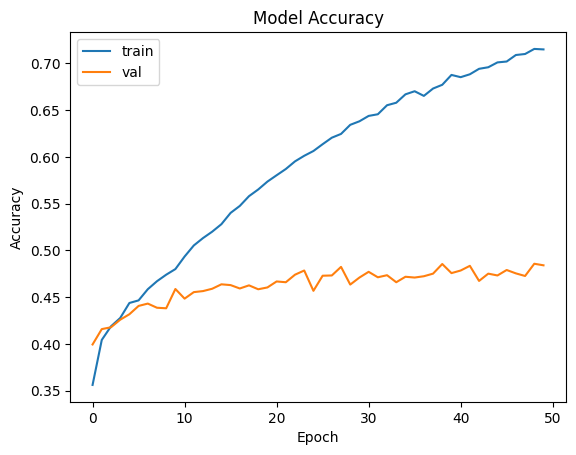

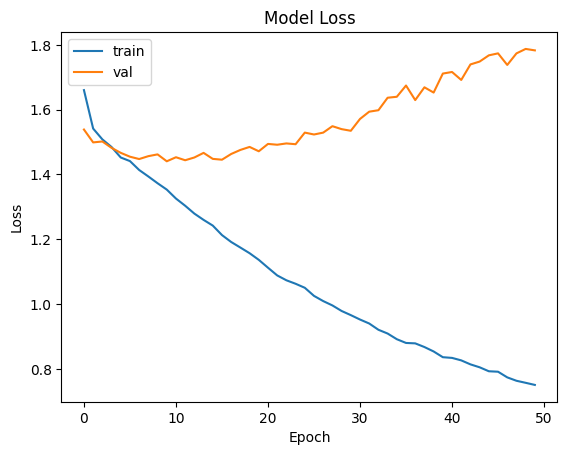

In [6]:
import matplotlib.pyplot as plt

# plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### Efficientnet-B0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

# Split the dataset into training, validation and testing sets
train_data = df[df['Usage'] == 'Training']
val_data = df[df['Usage'] == 'PublicTest']
test_data = df[df['Usage'] == 'PrivateTest']

# Preprocess the data
X_train = np.array([np.fromstring(image, np.uint8, sep=' ') for image in train_data['pixels']])
y_train = np_utils.to_categorical(train_data['emotion'], 7)
X_val = np.array([np.fromstring(image, np.uint8, sep=' ') for image in val_data['pixels']])
y_val = np_utils.to_categorical(val_data['emotion'], 7)
X_test = np.array([np.fromstring(image, np.uint8, sep=' ') for image in test_data['pixels']])
y_test = np_utils.to_categorical(test_data['emotion'], 7)

X_train = X_train.reshape(-1, 48, 48)
X_train = np.stack([X_train]*3, axis=-1)  # convert to RGB format

X_val = X_val.reshape(-1, 48, 48)
X_val = np.stack([X_val]*3, axis=-1)  # convert to RGB format

X_test = X_test.reshape(-1, 48, 48)
X_test = np.stack([X_test]*3, axis=-1)  # convert to RGB format

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Load the ResNet-50 model with pre-trained weights
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers to the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [ ]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
file_name = 'EfficientNetB0_best_model.h5'

checkpoint_path= os.path.join('checkpoint', file_name)


# ModelCheckpoint callback - save best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_frequency='epoch',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                mode='max')

# EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           restore_best_weights=True)


In [ ]:

# Train the model with data augmentation
history = model.fit(X_train, y_train, batch_size=32, epochs=50,
                    validation_data=(X_val, y_val), callbacks=[checkpoint, early_stop])


Epoch 1/50
898/897 [==============================] - ETA: 0s - loss: 1.8440 - accuracy: 0.2255
Epoch 1: val_accuracy improved from -inf to 0.24937, saving model to checkpoint/EfficientNetB0_best_model.h5


TypeError: ignored

# AffectNet

In [ ]:
import tensorflow as tf
import glob
import cv2
from matplotlib import pyplot
import numpy as np
import pandas as pd
import os
import shutil

### Data exploration

In [ ]:
# Path to folder containing training set
train_folder_path = "train_set/"
# Path to folder containing images
train_folder_path_img = train_folder_path + "images/"
# Path to folder containing annotations
train_folder_path_ano = train_folder_path + "annotations/"

In [ ]:
# image size
img_size = 48

img_dict = {"FileName": [], "Pixels": []}
image=0

for filename in sorted(glob.glob(train_folder_path_img +'*.jpg')):

  image = cv2.imread(filename)
  image = cv2.resize(image, (img_size, img_size))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  filename = filename[17:]
  img_dict["FileName"].append(filename)
  img_dict["Pixels"].append(image)
  print(filename)

0.jpg
1.jpg
10.jpg
100.jpg
100000.jpg
100001.jpg
100002.jpg
100004.jpg
100006.jpg
100008.jpg
100009.jpg
100011.jpg
100012.jpg
100013.jpg
100015.jpg
100017.jpg
100018.jpg
100019.jpg
10002.jpg
100020.jpg
100022.jpg
100023.jpg
100024.jpg
100025.jpg
100026.jpg
100028.jpg
10003.jpg
100031.jpg
100032.jpg
100033.jpg
100034.jpg
100037.jpg
100038.jpg
100039.jpg
10004.jpg
100040.jpg
100041.jpg
100042.jpg
100043.jpg
100044.jpg
100045.jpg
100046.jpg
100047.jpg
100048.jpg
100049.jpg
10005.jpg
100051.jpg
100052.jpg
100055.jpg
100056.jpg
100057.jpg
100058.jpg
100059.jpg
10006.jpg
100062.jpg
100063.jpg
100064.jpg
100065.jpg
100066.jpg
100068.jpg
100069.jpg
100071.jpg
100072.jpg
100074.jpg
100075.jpg
100077.jpg
10008.jpg
100080.jpg
100081.jpg
100082.jpg
100083.jpg
100085.jpg
100087.jpg
100089.jpg
100090.jpg
100092.jpg
100095.jpg
100096.jpg
1001.jpg
10010.jpg
100100.jpg
100101.jpg
100102.jpg
100103.jpg
100104.jpg
100107.jpg
100108.jpg
100109.jpg
10011.jpg
100111.jpg
100112.jpg
100113.jpg
100114.jpg
1001

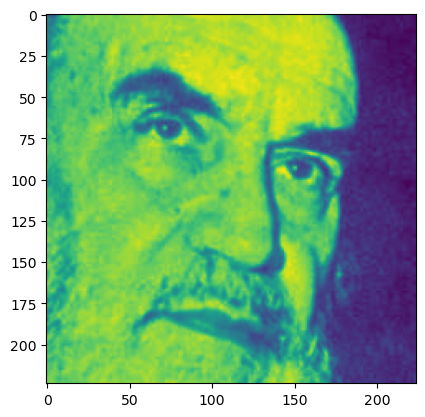

In [ ]:
pyplot.imshow(image.astype('float'))

In [ ]:
#load data into a DataFrame object:
df = pd.DataFrame(img_dict)

print(df) 

          FileName                                             Pixels
0            0.jpg  [[141, 118, 95, 79, 66, 47, 34, 33, 32, 77, 98...
1            1.jpg  [[2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1,...
2           10.jpg  [[100, 85, 74, 62, 78, 55, 47, 79, 70, 55, 63,...
3          100.jpg  [[56, 59, 59, 60, 63, 70, 70, 68, 71, 79, 86, ...
4       100000.jpg  [[39, 33, 33, 42, 46, 39, 40, 85, 72, 63, 54, ...
...            ...                                                ...
287646   99995.jpg  [[151, 148, 140, 136, 102, 98, 96, 86, 75, 69,...
287647   99996.jpg  [[40, 43, 51, 55, 59, 66, 72, 81, 83, 95, 100,...
287648   99997.jpg  [[202, 202, 201, 162, 142, 127, 127, 128, 129,...
287649   99998.jpg  [[138, 138, 119, 25, 14, 10, 9, 10, 18, 34, 19...
287650   99999.jpg  [[124, 144, 176, 186, 181, 190, 192, 189, 191,...

[287651 rows x 2 columns]


In [ ]:
df.shape

(287651, 2)

In [ ]:
df.Pixels.iloc[0]

array([[141, 118,  95, ..., 175, 172, 175],
       [127,  96,  83, ..., 178, 175, 177],
       [ 89,  77,  77, ..., 176, 175, 175],
       ...,
       [ 11,  51, 192, ..., 129, 134, 132],
       [  8,  29, 187, ..., 131, 135, 134],
       [  8,  13, 157, ..., 129, 132, 132]], dtype=uint8)

In [ ]:
df.Pixels.iloc[0].shape

(48, 48)

In [ ]:
exp = []
aro = []
val = []
lnd = []
for img in img_dict["FileName"]:
    exp.append(np.load(train_folder_path_ano+img[:-4] + '_exp.npy'))
    aro.append(np.load(train_folder_path_ano+img[:-4] + '_aro.npy'))
    val.append(np.load(train_folder_path_ano+img[:-4] + '_val.npy'))
    lnd.append(np.load(train_folder_path_ano+img[:-4] + '_lnd.npy'))


In [ ]:
tempExp = []
for i in exp:
    tempExp.append(int(i))

exp = tempExp

In [ ]:
df["Expression"] = exp
df["Arousal"] = aro
df["Valence"] = val
df["Landmarks"] = lnd

In [ ]:
print(df) 
# (0: Neutral, 1: Happy, 2: Sad, 3: Surprise, 4: Fear, 5: Disgust, 6: Anger, 7: Contempt)

          FileName                                             Pixels  \
0            0.jpg  [[141, 118, 95, 79, 66, 47, 34, 33, 32, 77, 98...   
1            1.jpg  [[2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1,...   
2           10.jpg  [[100, 85, 74, 62, 78, 55, 47, 79, 70, 55, 63,...   
3          100.jpg  [[56, 59, 59, 60, 63, 70, 70, 68, 71, 79, 86, ...   
4       100000.jpg  [[39, 33, 33, 42, 46, 39, 40, 85, 72, 63, 54, ...   
...            ...                                                ...   
287646   99995.jpg  [[151, 148, 140, 136, 102, 98, 96, 86, 75, 69,...   
287647   99996.jpg  [[40, 43, 51, 55, 59, 66, 72, 81, 83, 95, 100,...   
287648   99997.jpg  [[202, 202, 201, 162, 142, 127, 127, 128, 129,...   
287649   99998.jpg  [[138, 138, 119, 25, 14, 10, 9, 10, 18, 34, 19...   
287650   99999.jpg  [[124, 144, 176, 186, 181, 190, 192, 189, 191,...   

        Expression      Arousal     Valence  \
0                1   -0.0555556    0.785714   
1                0   0.004313

In [ ]:
df.shape

(287651, 6)

In [ ]:
df.Expression.unique()

array([1, 0, 6, 3, 4, 7, 2, 5], dtype=int64)

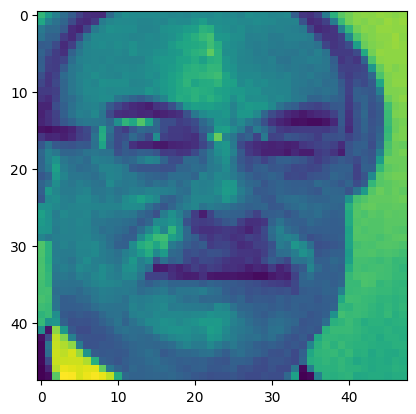

In [ ]:
pyplot.imshow(df.Pixels.loc[0].astype('float'))

In [ ]:
label_to_text = {0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger', 7: 'Contempt'}

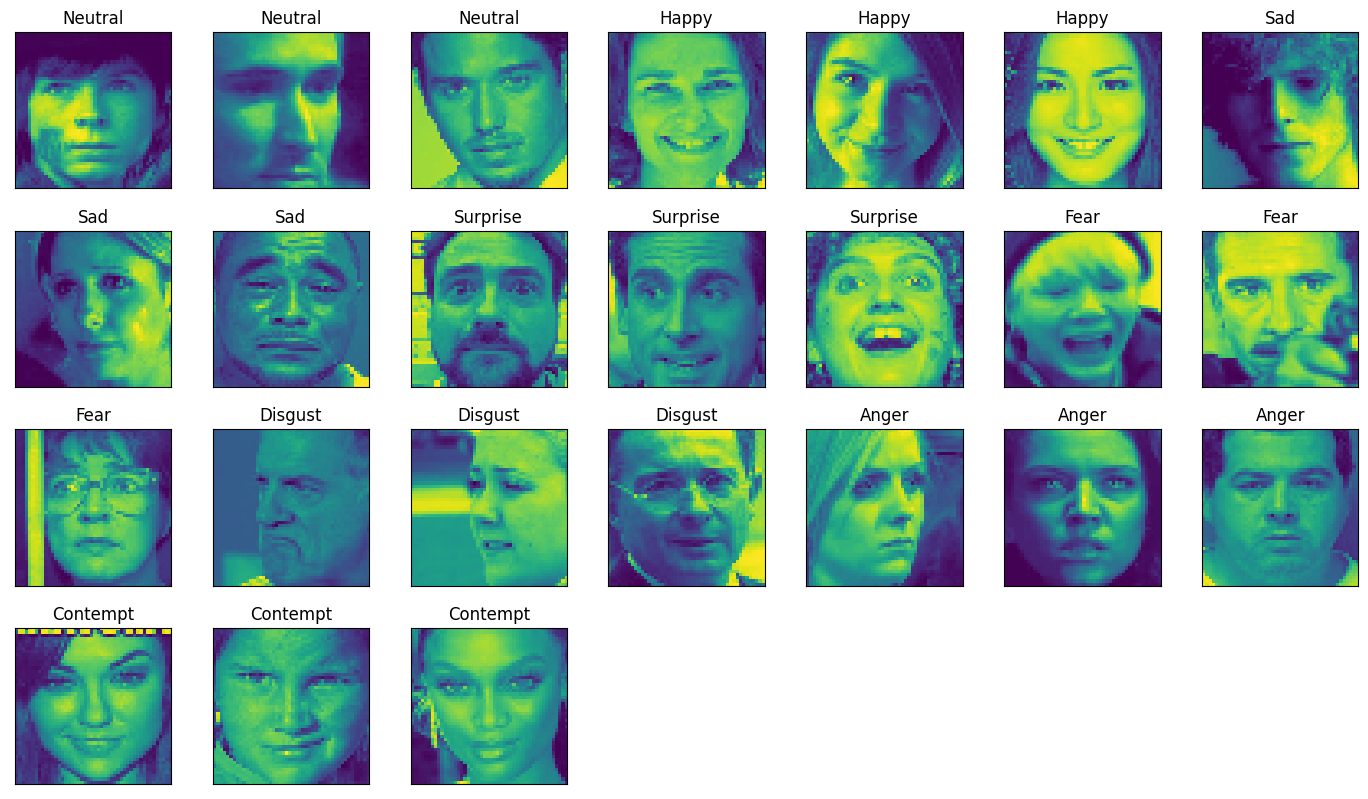

In [ ]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.Expression.unique()):
    for j in range(3):
        px = df[df.Expression==label].Pixels.iloc[k]
        px = px.astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [ ]:
df['Expression'].value_counts()

1    134415
0     74874
2     25459
6     24882
3     14090
4      6378
5      3803
7      3750
Name: Expression, dtype: int64

C:\Users\sadiq\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


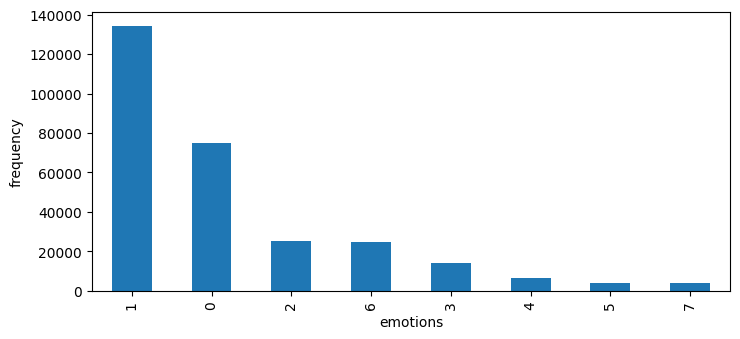

In [ ]:
pyplot.rcParams["figure.figsize"] = [7.50, 3.50]
pyplot.rcParams["figure.autolayout"] = True

fig, ax = pyplot.subplots()
# {0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger', 7: 'Contempt'}
df['Expression'].value_counts().plot(ax=ax, kind='bar', xlabel='emotions', ylabel='frequency')

pyplot.show()

### Data preprocessing

In [ ]:
X = df['Pixels']
type(X[0])

numpy.ndarray

In [ ]:
X = X.apply(lambda x : x.reshape(48, 48, 1).astype('float32'))
X = np.stack(X, axis=0)
X[0].shape

(48, 48, 1)

In [ ]:
y=df['Expression']
# y=np.array(y)
y[0]

1

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoded vectors
y = to_categorical(y, num_classes=8)

print('One-hot encoded labels:\n', y)

One-hot encoded labels:
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


### Simple CNN model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape=(48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1024, activation='relu'),
                                        tf.keras.layers.Dense(8, activation='softmax')
                                        
                                        ])

In [ ]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
basemodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
file_name = 'affectnet_best_model.h5'

checkpoint_path= os.path.join('checkpoint', file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_frequency='epoch',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                mode='max')

In [ ]:
basemodel.fit(X_train, y_train,epochs=20,validation_split=0.2,callbacks=call_back)

Epoch 1/20
5753/5753 [==============================] - ETA: 0s - loss: 1.2327 - accuracy: 0.5765
Epoch 1: val_accuracy did not improve from 0.69870
5753/5753 [==============================] - 238s 41ms/step - loss: 1.2327 - accuracy: 0.5765 - val_loss: 1.0553 - val_accuracy: 0.6341
Epoch 2/20
5752/5753 [============================>.] - ETA: 0s - loss: 1.0818 - accuracy: 0.6258
Epoch 2: val_accuracy did not improve from 0.69870
5753/5753 [==============================] - 234s 41ms/step - loss: 1.0819 - accuracy: 0.6257 - val_loss: 1.0519 - val_accuracy: 0.6314
Epoch 3/20
5752/5753 [============================>.] - ETA: 0s - loss: 1.0247 - accuracy: 0.6458
Epoch 3: val_accuracy did not improve from 0.69870
5753/5753 [==============================] - 235s 41ms/step - loss: 1.0248 - accuracy: 0.6457 - val_loss: 1.0154 - val_accuracy: 0.6483
Epoch 4/20
5753/5753 [==============================] - ETA: 0s - loss: 1.0032 - accuracy: 0.6536
Epoch 4: val_accuracy did not improve from 0.69

In [ ]:
loss, accuracy = basemodel.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

1798/1798 [==============================] - 40s 22ms/step - loss: 0.9355 - accuracy: 0.6906
Test loss: 0.9354631304740906
Test accuracy: 0.6906189918518066
